# Introduction

## Final Project Submission

***
- Student Name: Adam Marianacci
- Student Pace: Flex
- Scheduled project review date/time: TBD
- Instructor Name: Morgan Jones

# Business Understanding

Coldwell Banker wants to buy undervalued homes in certain zipcodes to minimally renovate and sell for a profit. It is my job to find homes that are being listed significanty lower than the median price and look into what variables are causing these lowered prices so that I can properly advise Coldwell Banker on which homes to target. 

# Data Understanding

This project uses the King County House Sales dataset. It contains over 30,000 entries of data related to the sale price of houses, number of bedrooms,bathrooms and floors, square footage, addresses, and more. The dataset is suitable for this project because it has enough information to reveal which homes are truly being undervalued in certain zipcodes. After analyzing the price, location, and other various specifications and amenities of homes I will be able to make informed recommendations to the real estate agency.

# Data Preperation

I started by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

I did not want any information in the dataframe to be truncated. I searched `pandas output truncated` in google and found this [solution](https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver).

In [2]:
pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be

In [3]:
# Loading the dataframe
kc_house_data_df = pd.read_csv('data/kc_house_data.csv', index_col=0)

In [4]:
# Previewing the dataframe
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",47.461975,-122.19052
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",47.711525,-122.35591
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",47.502045,-122.22520
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",47.566110,-122.29020
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",47.532470,-122.07188


I wanted to give the data in the price column a dollar sign and add commas for readability. I typed `adding a dollar sign and adding commas using a lambda function` into google and found this [solution](https://stackoverflow.com/questions/43102734/format-a-number-with-commas-to-separate-thousands).

In [15]:
kc_house_data_df['price'] = kc_house_data_df['price'].apply(lambda x: '${:,.2f}'.format(x))

Previewing the df again to see if it worked, all good!

In [16]:
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address
id,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,"$675,000.00",4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States"
8910500230,12/13/2021,"$920,000.00",5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States"
1180000275,9/29/2021,"$311,000.00",6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States"
1604601802,12/14/2021,"$775,000.00",3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States"
8562780790,8/24/2021,"$592,500.00",2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States"


There are 24 columns and 30155 entries. There is only a handful of missing values in the "heat_source" and "sewer_system" columns. The data types consist of objects, integers, and floats.

In [5]:
# Gathering information about the datatypes within the dataframe,as well as looking for missing values
kc_house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30155 non-null  object 
 1   price          30155 non-null  float64
 2   bedrooms       30155 non-null  int64  
 3   bathrooms      30155 non-null  float64
 4   sqft_living    30155 non-null  int64  
 5   sqft_lot       30155 non-null  int64  
 6   floors         30155 non-null  float64
 7   waterfront     30155 non-null  object 
 8   greenbelt      30155 non-null  object 
 9   nuisance       30155 non-null  object 
 10  view           30155 non-null  object 
 11  condition      30155 non-null  object 
 12  grade          30155 non-null  object 
 13  heat_source    30123 non-null  object 
 14  sewer_system   30141 non-null  object 
 15  sqft_above     30155 non-null  int64  
 16  sqft_basement  30155 non-null  int64  
 17  sqft_garage    30155 non-null  int64

I wanted to confirm and see clearly how many missing values there were in each column.

In [6]:
kc_house_data_df.isnull().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

Since there were only 32 missing values from "heat_source" and 14 missing values from "sewer_system" out of 30,155 entries, I decided to remove the rows that contained missing values. I typed `remove rows that contain missing values in a  pandas df` into google and found this [solution](https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan).

In [7]:
kc_house_data_df = kc_house_data_df.dropna(subset = ["heat_source", "sewer_system"])

Checking to see if my code worked, it did!

In [8]:
kc_house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30111 non-null  object 
 1   price          30111 non-null  float64
 2   bedrooms       30111 non-null  int64  
 3   bathrooms      30111 non-null  float64
 4   sqft_living    30111 non-null  int64  
 5   sqft_lot       30111 non-null  int64  
 6   floors         30111 non-null  float64
 7   waterfront     30111 non-null  object 
 8   greenbelt      30111 non-null  object 
 9   nuisance       30111 non-null  object 
 10  view           30111 non-null  object 
 11  condition      30111 non-null  object 
 12  grade          30111 non-null  object 
 13  heat_source    30111 non-null  object 
 14  sewer_system   30111 non-null  object 
 15  sqft_above     30111 non-null  int64  
 16  sqft_basement  30111 non-null  int64  
 17  sqft_garage    30111 non-null  int64

"Lat", "Long", did not seem relevant since I am looking into zipcodes. I dropped them from the dataframe to simplify and condense the df.

In [9]:
kc_house_data_df.drop(['lat', 'long',], axis=1, inplace=True)

In [10]:
kc_house_data_df['address']

id
7399300360         2102 Southeast 21st Court, Renton, Washington 98055, United States
8910500230     11231 Greenwood Avenue North, Seattle, Washington 98133, United States
1180000275          8504 South 113th Street, Seattle, Washington 98178, United States
1604601802        4079 Letitia Avenue South, Seattle, Washington 98118, United States
8562780790      2193 Northwest Talus Drive, Issaquah, Washington 98027, United States
                                               ...                                   
7834800180        4673 Eastern Avenue North, Seattle, Washington 98103, United States
194000695        4131 44th Avenue Southwest, Seattle, Washington 98116, United States
7960100080    910 Martin Luther King Jr Way, Seattle, Washington 98122, United States
2781280080      17127 114th Avenue Southeast, Renton, Washington 98055, United States
9557800100            18615 7th Avenue South, Burien, Washington 98148, United States
Name: address, Length: 30111, dtype: object

In [11]:
kc_house_data_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,3.011100e+04,30111.000000,30111.000000,30111.000000,3.011100e+04,30111.000000,30111.000000,30111.000000,30111.000000,30111.000000,30111.000000,30111.000000
mean,1.108971e+06,3.415197,2.335708,2113.342798,1.664880e+04,1.543506,1810.389658,476.617117,330.475308,217.451264,1975.162299,90.792767
std,8.965158e+05,0.979755,0.888293,973.453260,5.993303e+04,0.567789,877.726339,579.805355,285.725020,245.301991,32.052930,416.197627
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000
25%,6.492360e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.477000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000
75%,1.300000e+06,4.000000,3.000000,2620.000000,1.056800e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000


# Data Analysis

<AxesSubplot:>

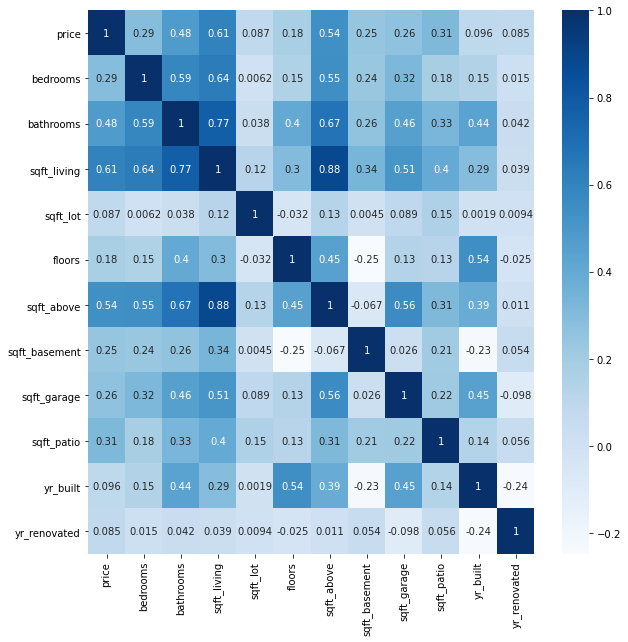

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
cor = kc_house_data_df.corr()
sns.heatmap(cor,cmap="Blues",annot=True)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

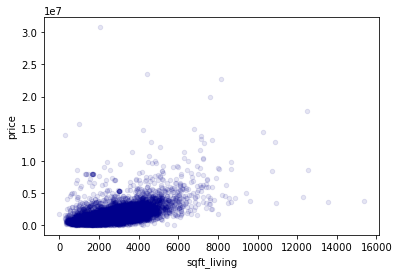

In [13]:
kc_house_data_df.plot.scatter(
    x='sqft_living',
    y='price',
    c='DarkBlue',
    alpha = 0.1)

# Modeling

In [14]:
import statsmodels.api as sm